<a href="https://colab.research.google.com/github/Yusuke710/ROSO/blob/main/ROSO_UnseenObj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# open on colab


In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You can move your own generated file from cliport/demo.py or use already generated data in https://drive.google.com/drive/folders/1teo0r8G2c9SX0zu9gNhidOgKWESlK8QZ?usp=drive_link

## Parameters

In [ ]:
mode = 'unseen' # 'unseen'

# prompt mapping from other file
unseen2seen = {'ball puzzle': 'crayon box', 'black and blue sneakers': 'black shoe with orange stripes', 'black shoe with green stripes': 'black shoe with orange stripes', 'brown fedora': 'black fedora', 'dinosaur figure': 'rhino figure', 'hammer': 'tablet', 'light brown boot with golden laces': 'black boot with leopard print', 'lion figure': 'rhino figure', 'pepsi max box': 'pepsi gold caffeine free box', 'pepsi next box': 'pepsi wild cherry box', 'porcelain salad plate': 'porcelain cup', 'porcelain spoon': 'porcelain cup', 'red and white striped towel': 'green and white striped towel', 'red cup': 'porcelain cup', 'screwdriver': 'scissors', 'toy train': 'toy school bus', 'unicorn toy': 'android toy', 'white razer mouse': 'black razer mouse', 'yoshi figure': 'mario figure'}

# metadata from CLIPort pipeline
metadata_path = '/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/metadata.csv'

# raw_images on the drive
raw_images_dir = '/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/raw_images'

# directory to store edited images
# dir/each_object
store_dir = '/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images'


In [ ]:
# model parameters

# detection param
box_threshold = 0.2
text_threshold = 0.2


# num_inference_steps
num_inference_steps = 20
# strength
strength = 1 # how much to transform the reference image. 1 means ignoring the image being replaced

# number of image to generate using SD
num_to_generate = 3

# seed
seed = 42

## Install

In [ ]:
%cd /content

# GSAM
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/content/Grounded-Segment-Anything
/content/Grounded-Segment-Anything/GroundingDINO
  Preparing metadata (setup.py) ... done
/content/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
/content/Grounded-Segment-Anything


In [ ]:
# SDXL
!pip install transformers
!pip install accelerate
!pip install safetensors
!pip install diffusers

## Imports

In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy
import pandas as pd

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import random
from diffusers import StableDiffusionXLInpaintPipeline


from huggingface_hub import hf_hub_download

## Load models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!nvidia-smi

Sat Nov 18 13:00:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2023-11-18 13:00:37--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.106, 52.84.251.114, 52.84.251.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.5’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   125MB/s    in 26s     

2023-11-18 13:01:02 (95.7 MB/s) - ‘sam_vit_h_4b8939.pth.5’ saved [2564550879/2564550879]



## Inference utils

### Grounding DINO for detection

In [ ]:
# detect object using grounding DINO
def detect_multiple(image, image_source, text_prompt, model, box_threshold = box_threshold, text_threshold = text_threshold):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

In [ ]:
def detect(image, image_source, text_prompt, model, box_threshold=box_threshold, text_threshold=text_threshold):
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    if logits.numel() == 0:
        print("Logits tensor is empty or contains no valid values.")
        return None, None

    highest_prob_index = logits.argmax()
    highest_prob_box = boxes[highest_prob_index].unsqueeze(0)
    highest_prob_logits = logits[highest_prob_index].unsqueeze(0)

    annotated_frame_with_highest_prob_box = image_source.copy()
    annotated_frame_with_highest_prob_box = annotate(image_source=annotated_frame_with_highest_prob_box, boxes=highest_prob_box, logits=highest_prob_logits, phrases=[phrases[highest_prob_index]])
    annotated_frame_with_highest_prob_box = annotated_frame_with_highest_prob_box[...,::-1]  # BGR to RGB

    return annotated_frame_with_highest_prob_box, highest_prob_box


### SAM for segmentation

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

### Stable Diffusion for inpainting

In [ ]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0][0])
    for i in range(len(masks)):
        merged_mask = np.logical_or(merged_mask, masks[i][0].cpu().numpy())
    return merged_mask


# Function to convert normalized coordinates to pixel coordinates
def normalized_to_pixel_coordinates(normalized_box, image_width, image_height):
    x_min, y_min, width, height = normalized_box

    # adjust the point from the centre of the boundary to the left top corner
    x_min = x_min - width/2
    y_min = y_min - height/2

    # convert to pixel space
    x_min_pixel = int(x_min * image_width)
    y_min_pixel = int(y_min * image_height)
    x_max_pixel = int((x_min + width) * image_width)
    y_max_pixel = int((y_min + height) * image_height)

    #print(f'integer: {x_min_pixel}, {y_min_pixel}, {x_max_pixel}, {y_max_pixel}')


    return x_min_pixel, y_min_pixel, x_max_pixel, y_max_pixel


# extract bounding box to inpaint
def get_image_inside_boundingbox(image_source, box): # could be mask image
  x_min, y_min, x_max, y_max = box
  image_inside_boundingbox = image_source[y_min:y_max, x_min:x_max]
  return image_inside_boundingbox


# Function to replace the region inside the boundary box with the resized image
def replace_region_with_resized_image(image_source, box, image_replace):
    x_min, y_min, x_max, y_max = box
    region_width = x_max - x_min
    region_height = y_max - y_min


    # inputs are PIL
    # convert to np
    image_source_np = np.array(image_source)
    resized_image_replace = image_replace.resize((region_width, region_height))
    resized_image_replace_np = np.array(resized_image_replace)
    #resized_image_replace_np = resized_image_replace_np, (region_width,region_height))

    # convert np back to PIL
    image_source_np[y_min:y_max, x_min:x_max] = resized_image_replace_np
    image_source_edited = Image.fromarray(image_source_np)
    return image_source_edited

In [ ]:
def generate_image(image, mask, prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  result = pipe(prompt=prompt, image=in_image, mask_image=in_mask, num_inference_steps=num_inference_steps, strength=strength, generator=torch.manual_seed(seed)).images[0]

  return result.resize((w, h))

### Free memory

Once the prompt embeddings have been created. We do not need the text encoder anymore. However, it is still in memory on the GPU. We need to remove it so that we can load the UNet.

It's non-trivial to free PyTorch memory. We must garbage collect the Python objects which point to the actual memory allocated on the GPU.

In [ ]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()

## Inference on a multiple images

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


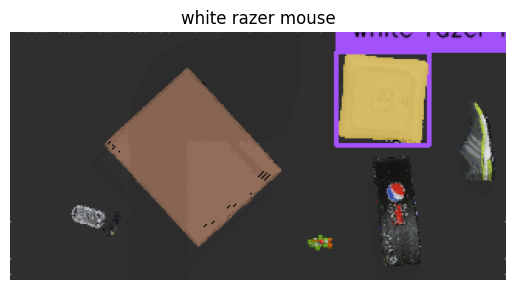

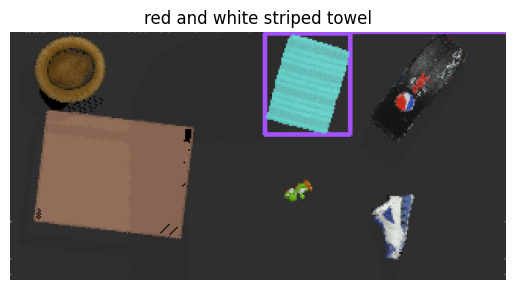

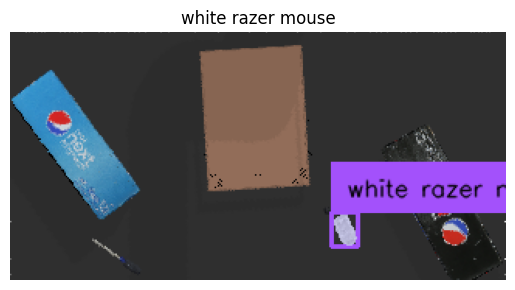

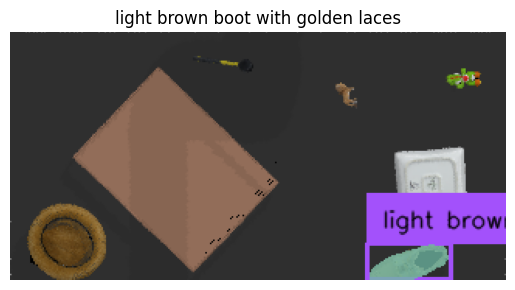

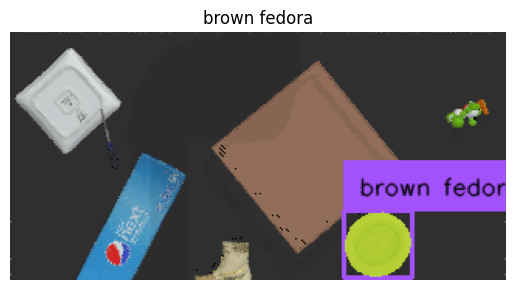

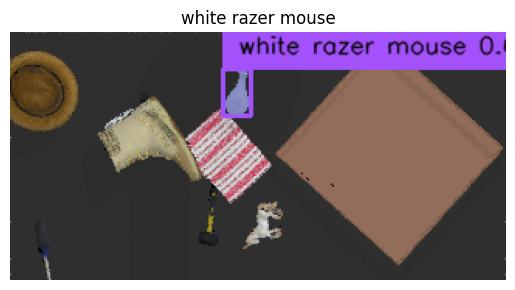

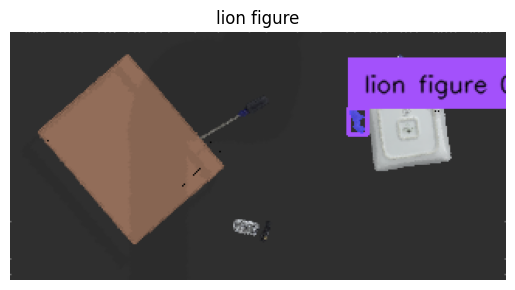

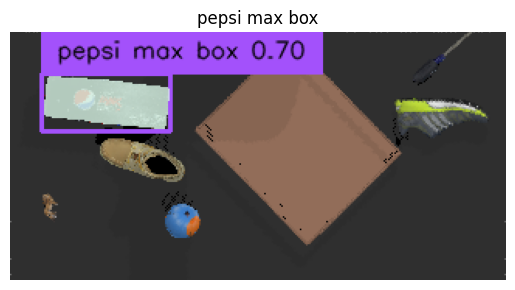

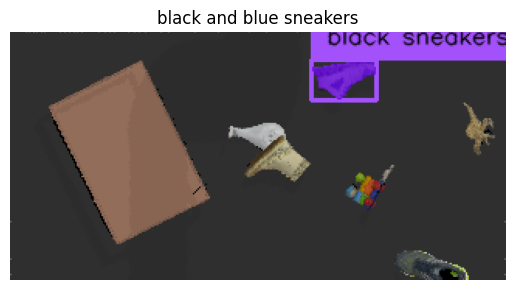

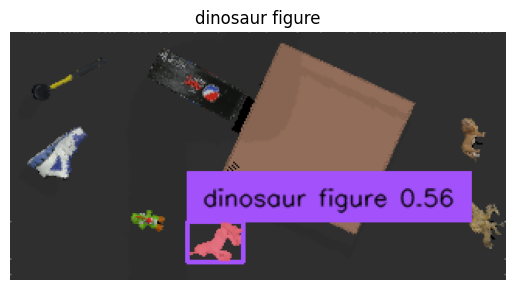

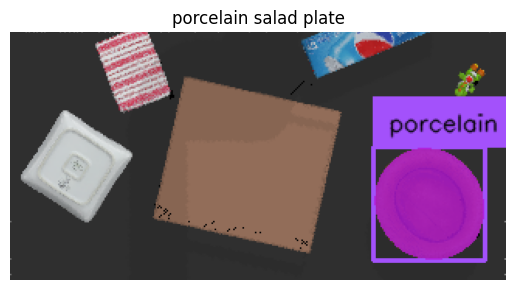

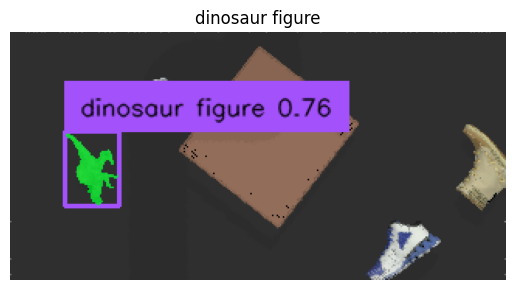

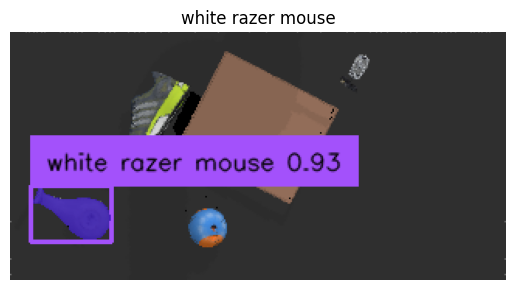

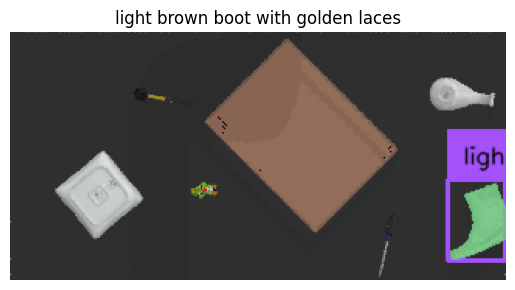

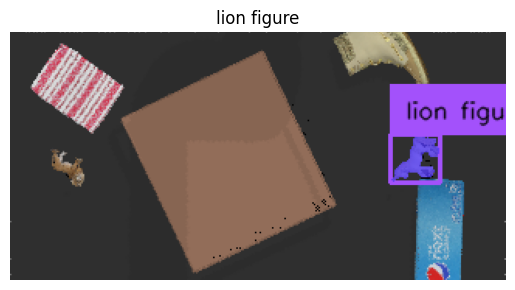

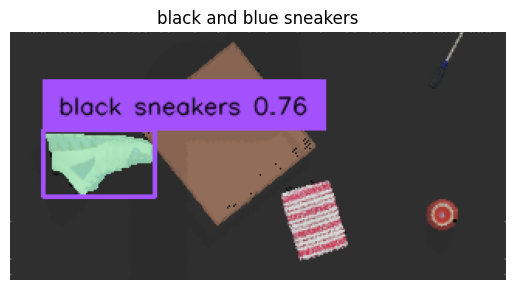

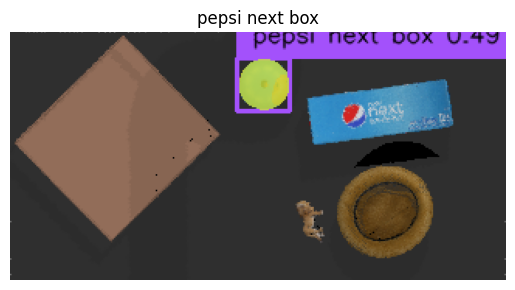

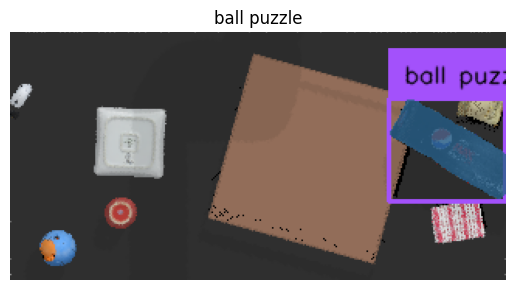

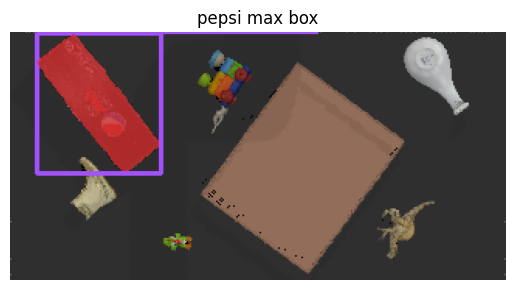

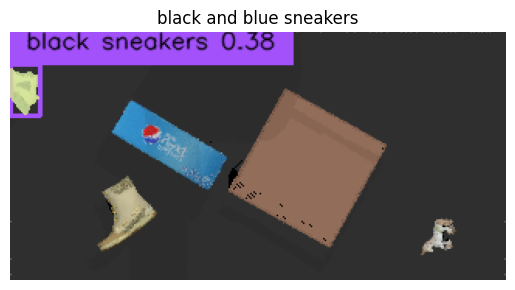

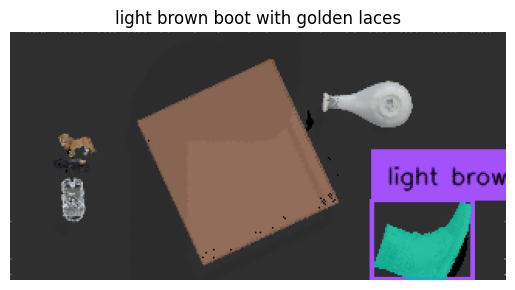

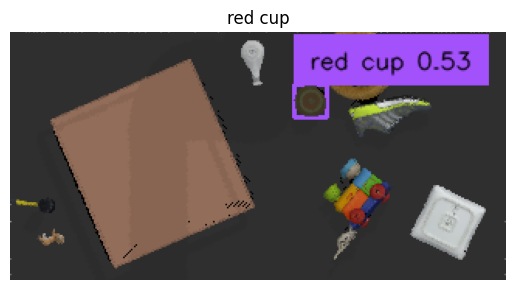

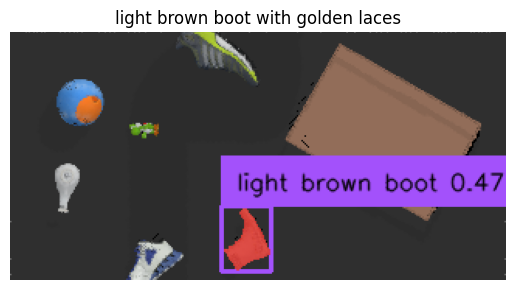

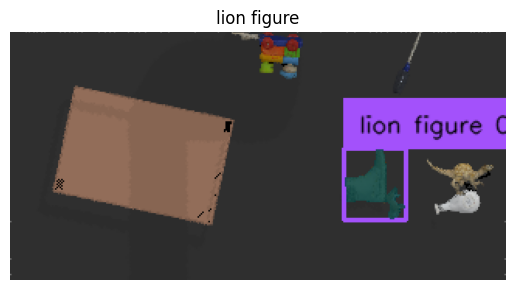

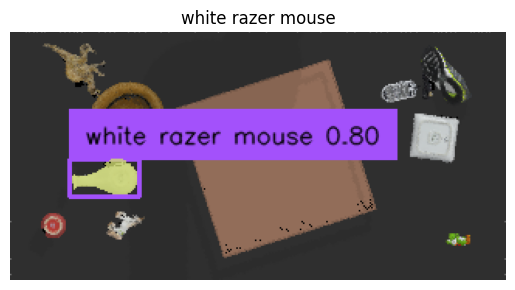

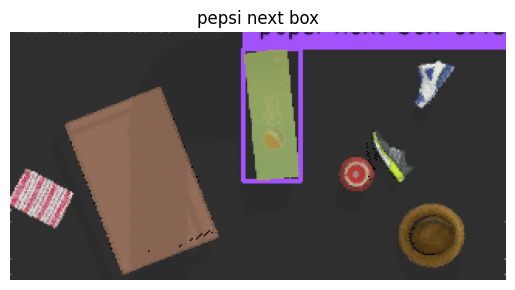

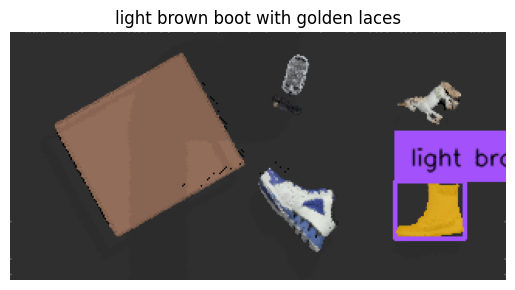

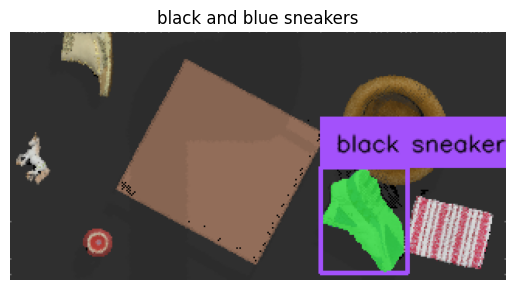

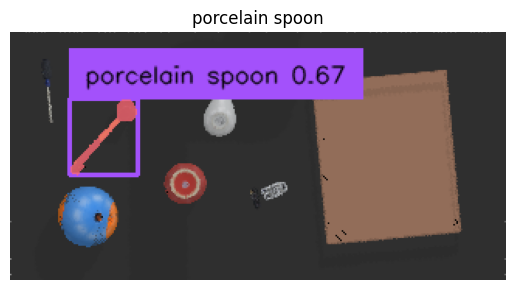

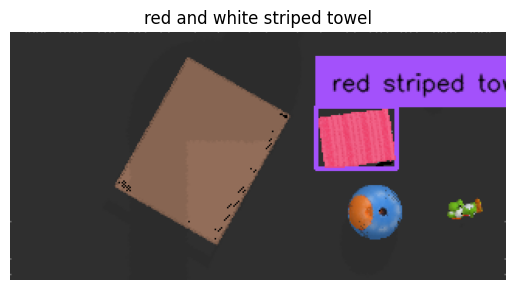

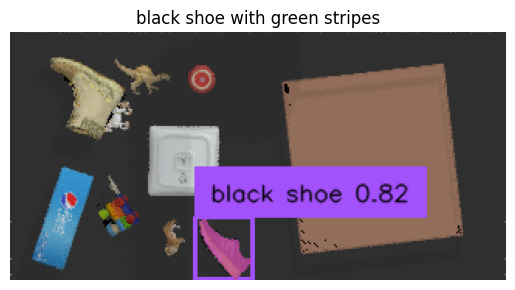

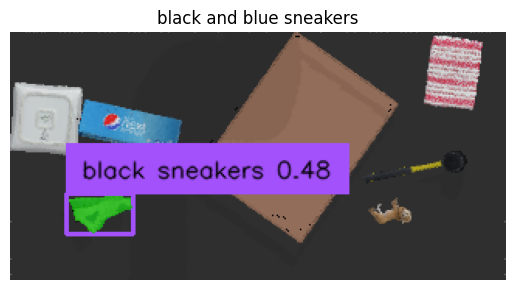

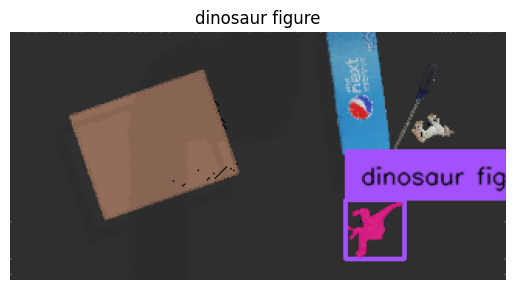

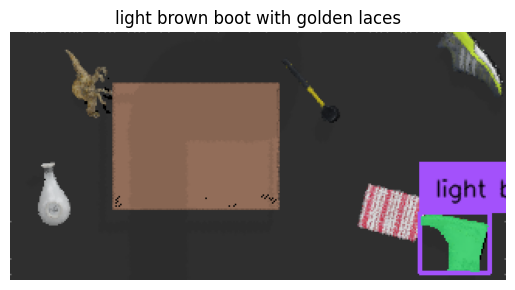

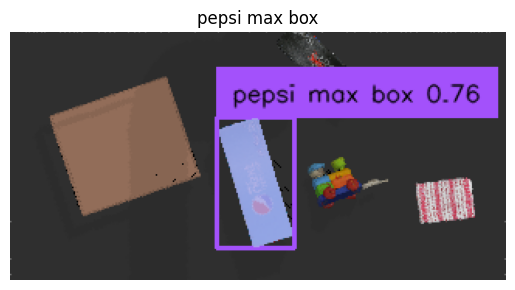

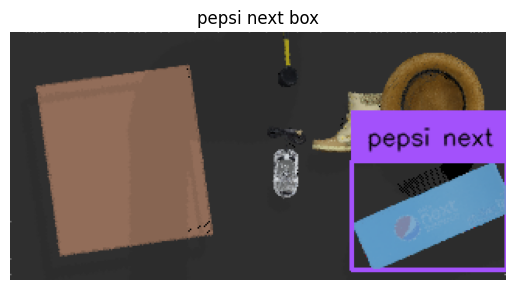

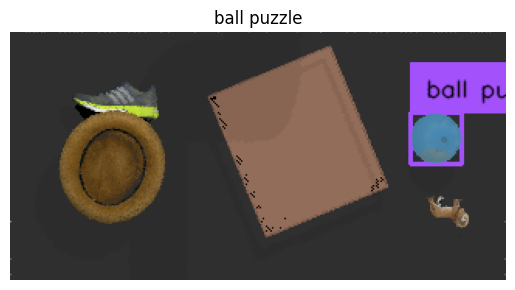

GSAM could not detect objects in 0 images


In [ ]:
#@markdown Load raw images and prepare masks

# From metadata, get image and object to detect
# Metadata needs to store relative paths
df = pd.read_csv(metadata_path)
# Filter the DataFrame based on the condition
fail_rows = df[df['success'] == False]

raw_images = [os.path.join(raw_images_dir, raw_image) for raw_image in sorted(os.listdir(raw_images_dir))]

# Store processed data in a dictionary for each image
image_data_list = []
non_detected_count = 0

for index, row in fail_rows.iterrows():
    img_path = raw_images[index]
    object_name = row['object_name']
    GSAM_prompt = object_name

    # If the mode is unseen, map the unseen object to a seen object.
    if mode == 'unseen':
        object_name = unseen2seen[object_name]

    # Load images
    image_source, image = load_image(img_path)
    image_source_pil = Image.fromarray(image_source)

    # Detect
    annotated_frame, detected_boxes = detect(image, image_source, text_prompt=GSAM_prompt, model=groundingdino_model)

    # Skip if not detected
    if detected_boxes is None:
        non_detected_count += 1
        continue

    # Segment
    segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
    annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)

    # display annotated_frame_with_mask
    plt.imshow(annotated_frame_with_mask)
    plt.title(GSAM_prompt)
    plt.axis('off')  # Turn off axes
    plt.show()

    # Create mask from segmentation
    mask = merge_masks(segmented_frame_masks)

    # Convert the detected_boxes from normalized coordinates to pixel coordinates
    image_width, image_height = image_source.shape[1], image_source.shape[0]
    detected_boxes_pixel_coords = [normalized_to_pixel_coordinates(box.squeeze().tolist(), image_width, image_height) for box in detected_boxes]

    # Extract the detected frame
    mask_frames = [Image.fromarray(get_image_inside_boundingbox(mask, box)) for box in detected_boxes_pixel_coords]
    image_frames = [Image.fromarray(get_image_inside_boundingbox(image_source, box)) for box in detected_boxes_pixel_coords]

    # Store processed data in a dictionary
    image_data = {
        'raw_image_path': img_path,
        'object_name': object_name,
        'image_source_pil': image_source_pil,
        'detected_boxes_pixel_coords': detected_boxes_pixel_coords,
        'mask_frames': mask_frames,
        'image_frames': image_frames
    }
    image_data_list.append(image_data)

# Now you have the processed data for each image in the image_data_list
# You can access the processed data for each image using the dictionary keys
print(f'GSAM could not detect objects in {non_detected_count} images')

In [ ]:
# @title free memory
# clear GDINO and SAM for memory limit
del groundingdino_model
del sam_predictor
flush()

In [ ]:
# @title load SDXL
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to(device)

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLInpaintPipeline {
  "_class_name": "StableDiffusionXLInpaintPipeline",
  "_diffusers_version": "0.23.1",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10009_white_razer_mouse/0.png


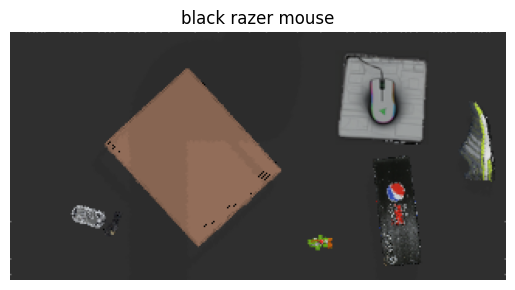

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10009_white_razer_mouse/1.png


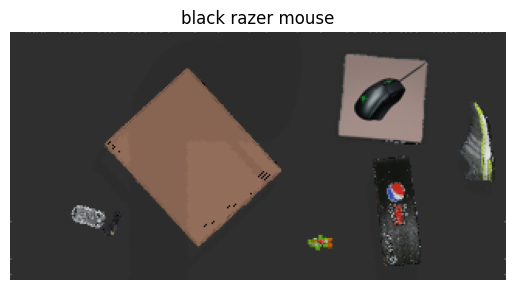

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10009_white_razer_mouse/2.png


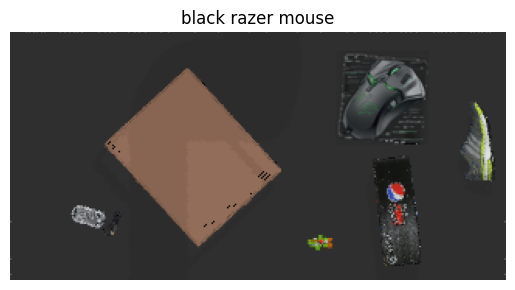

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10015_red_and_white_striped_towel/0.png


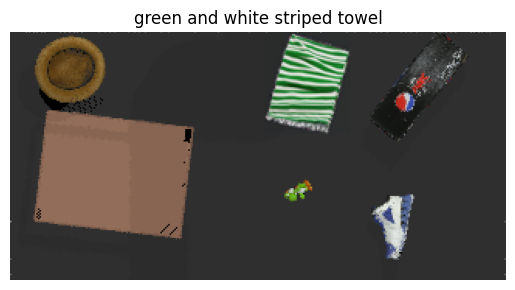

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10015_red_and_white_striped_towel/1.png


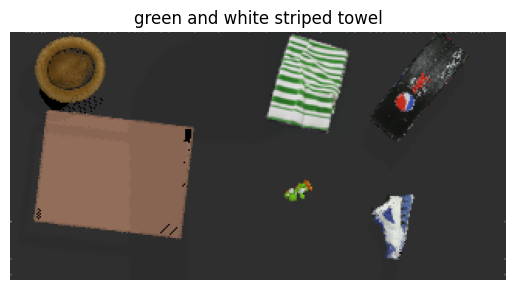

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10015_red_and_white_striped_towel/2.png


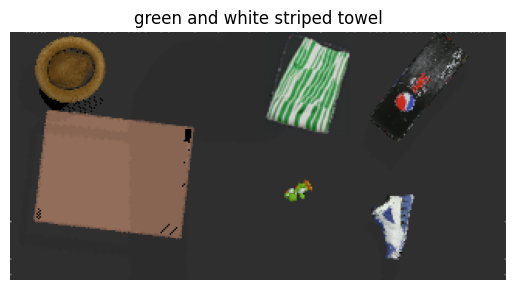

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10017_white_razer_mouse/0.png


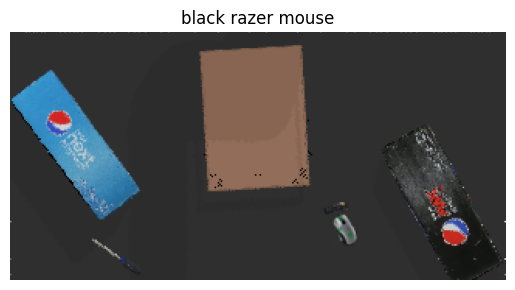

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10017_white_razer_mouse/1.png


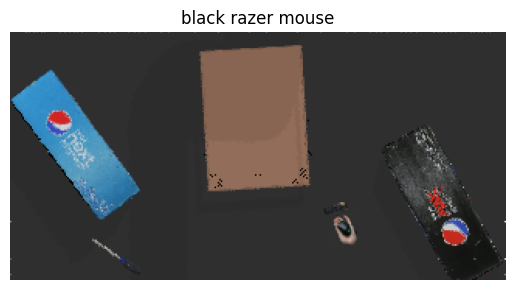

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10017_white_razer_mouse/2.png


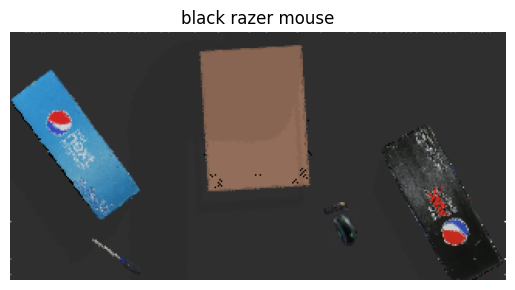

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10023_light_brown_boot_with_golden_laces/0.png


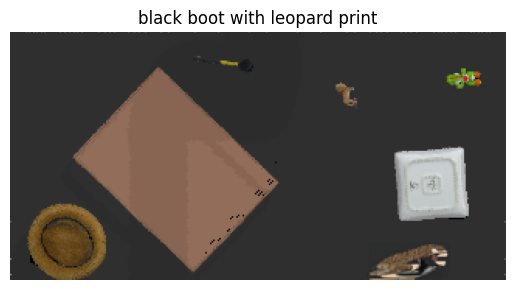

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10023_light_brown_boot_with_golden_laces/1.png


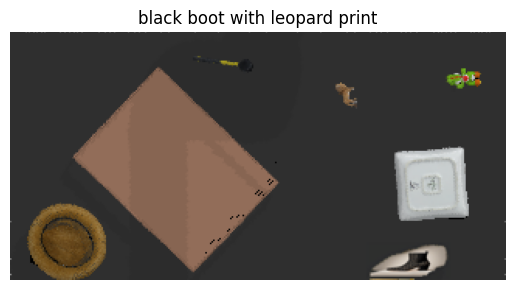

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10023_light_brown_boot_with_golden_laces/2.png


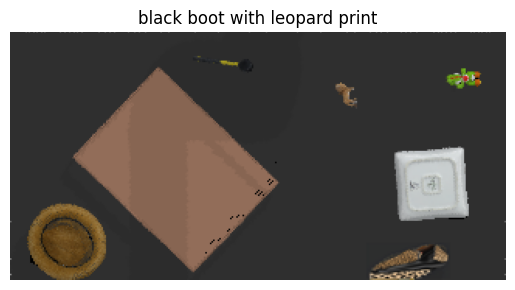

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10029_brown_fedora/0.png


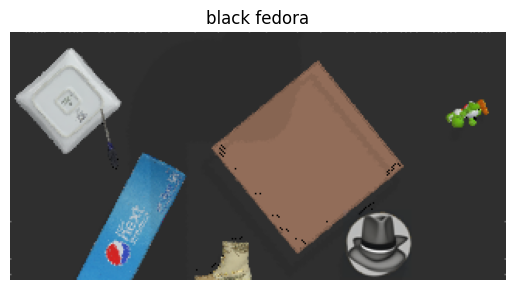

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10029_brown_fedora/1.png


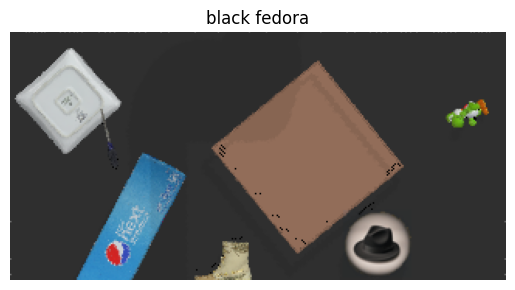

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10029_brown_fedora/2.png


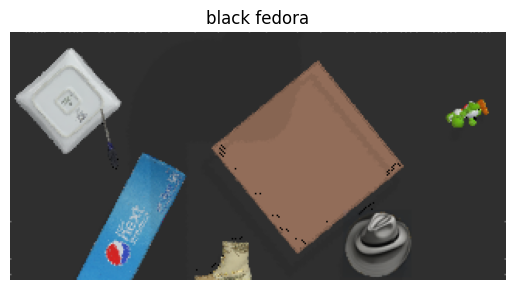

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10049_white_razer_mouse/0.png


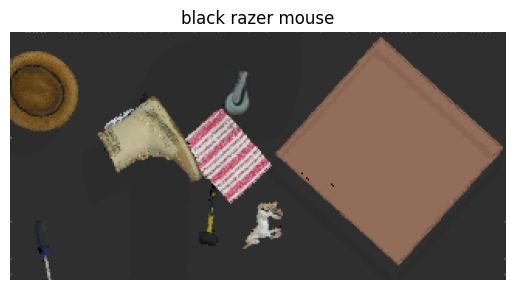

  0%|          | 0/20 [00:00<?, ?it/s]

/content/drive/MyDrive/ROSO/data/packing-unseen-google-object-test/edited_images/10049_white_razer_mouse/1.png


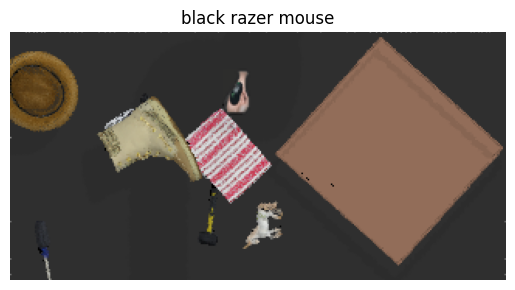

KeyboardInterrupt: ignored

In [ ]:
# @title SDXL image generation

# Generate the SDXL prompt
sdxl_prompt_template = 'a single {}'

# Iterate through the list of image_data_list to generate M number of edited frames
for i, image_data in enumerate(image_data_list):
    # Load data from image_data
    raw_image_path = image_data['raw_image_path']
    detected_boxes_pixel_coords = image_data['detected_boxes_pixel_coords']
    image_source_pil = image_data['image_source_pil']
    image_frames_pil = image_data['image_frames']
    mask_frames_pil = image_data['mask_frames']
    object_name = image_data['object_name']
    #object_name = 'black fedora' # variant of the experiment. comment it for unseen obj to seen obj editing, 'nintendo 3ds', 'black fedora'

    # Generate the SDXL prompt
    sdxl_prompt = sdxl_prompt_template.format(object_name)

    # Initialize edited image from the original image
    image_source_edited = image_source_pil.copy()

    # Go through all the detected objects in the image frame and inpaint according to the prompt
    for edit_iter in range(num_to_generate):
        modifications = []

        for object_id in range(len(image_frames_pil)):
            generated_image = generate_image(image=image_frames_pil[object_id], mask=mask_frames_pil[object_id], prompt=sdxl_prompt, pipe=pipe, seed=seed + edit_iter)
            modifications.append((detected_boxes_pixel_coords[object_id], generated_image))

        # Apply modifications to the edited image
        for box, edited_region in modifications:
            image_source_edited = replace_region_with_resized_image(image_source_edited, box, edited_region)

        # Save edited image
        filename_without_extension = os.path.splitext(os.path.basename(raw_image_path))[0]
        dir_path = os.path.join(store_dir, filename_without_extension)
        if not os.path.exists(dir_path):
          os.makedirs(dir_path)
        save_path = os.path.join(dir_path, str(edit_iter) + '.png')
        #save_path = os.path.join(store_dir, filename_without_extension, str(edit_iter) + '.png')
        print(save_path)

        image_source_edited.save(save_path)

        # Display the image
        plt.imshow(image_source_edited)
        plt.title(object_name)
        plt.axis('off')  # Turn off axes
        plt.show()
